In [25]:
import tensorflow as tf

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import pathlib
import random

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
root_path = "datasets/Interior_Exterior_Scene_Classification"

# 0. Setting up the machine

In [29]:
'''
MAC USERS: Make sure you have installed
pip install tensorflow-macos
pip install tensorflow-metal

''' 

'\nMAC USERS: Make sure you have installed\npip install tensorflow-macos\npip install tensorflow-metal\n\n'

In [30]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [31]:
# FIX ERROR FOR TENSORFLOW

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# 1. Organize and clean the data

In [32]:
os.listdir(root_path)

['.DS_Store', 'Exterior', 'Interior']

In [33]:
# reorganize data to have train, test and validation folder structure
import os
import shutil
import random

In [34]:
random.seed(42)

source_folders = ['interior', 'exterior']
folders = ['train','test','val']

ratios = {'train': 0.8, 'test': 0.1, 'val': 0.1}

# create folders
for folder in folders:
    for source_folder in source_folders:
        os.makedirs(os.path.join(root_path, folder, source_folder), exist_ok=True)

In [35]:
# split images

for category in source_folders:
    source_folder = os.path.join(root_path, category)
    images = os.listdir(source_folder)
    random.shuffle(images)
    
    for i, image in enumerate(images):
        if i < len(images) * ratios['train']:
            folder = 'train'
        elif i < len(images) * (ratios['train'] + ratios['test']):
            folder = 'test'
        else:
            folder = 'val'
        shutil.move(os.path.join(source_folder, image), os.path.join(root_path, folder, category, image))


In [36]:
# delete legacy folders (if exists)
for source_folder in source_folders:
    folder_path = os.path.join(root_path, source_folder)
    if os.path.exists(folder_path):  # Check if the folder exists
        shutil.rmtree(folder_path)

In [37]:
import pathlib
# find and delete all images that not .jpeg or .png
for path in pathlib.Path(root_path).rglob('*'):
    if path.is_file():
        if path.suffix != '.jpeg' and path.suffix != '.png' and path.suffix != '.jpg':
            print(path)
            os.remove(path)

datasets/Interior_Exterior_Scene_Classification/.DS_Store


# 2. IDE Process to see how balanced the data is

In [38]:
os.listdir(root_path)

['test', 'train', 'val']

In [39]:
# to show labels we have
os.listdir(root_path + "/train")

['exterior', 'interior']

In [40]:
# to show count of images we have
num_fractured_bone_images = len(os.listdir(root_path + "/train/exterior"))
print(num_fractured_bone_images)

num_not_fractured_bone_images = len(os.listdir(root_path + "/train/interior"))
print(num_not_fractured_bone_images)

800
800


In [41]:
# get class names
data_dir = pathlib.Path(root_path + "/train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['exterior' 'interior']


### Function to see the random image

In [42]:
def random_img(dirpath, target_class):
    directory = dirpath + "/" + target_class
    random_img = random.sample(os.listdir(directory), 1)

    img = mpimg.imread(directory + "/" + random_img[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

    print(f"Image shape: {img.shape}")

    return img

Image shape: (480, 854, 3)


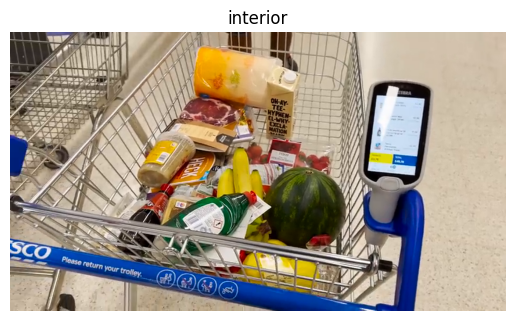

In [44]:
img = random_img(root_path + "/train", "interior")

### Prepare data into formats we want

In [111]:
train_dir = root_path + "/train"
test_dir = root_path + "/test"
val_dir = root_path + "/val"

In [112]:
# rescale 1./255 - to normalize pixel values between 0 and 1 to improve model training
# it has nothing to do with the size of images
# rescale is for pixel values, and target_size handles image dimensions.

train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=20,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)                                      
val_datagen = ImageDataGenerator(rescale=1./255)     

In [113]:
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                                target_size=(224, 224), 
                                                class_mode="binary", 
                                                batch_size=32,
                                                shuffle=True)
test_data = test_datagen.flow_from_directory(directory=test_dir, 
                                                target_size=(224, 224), 
                                                class_mode="binary", 
                                                batch_size=32)
val_data = val_datagen.flow_from_directory(directory=val_dir, 
                                            target_size=(224, 224), 
                                            class_mode="binary", 
                                            batch_size=32)

"""
NOTE: flow_from_directory, it only counts the images in the specified directories and organizes them 
into batches based on your parameters (e.g., batch_size and class_mode). 
The actual processing (resizing, rescaling, etc.) happens only when you 
start iterating over the generator (e.g., during model training or validation).
"""

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


'\nNOTE: flow_from_directory, it only counts the images in the specified directories and organizes them \ninto batches based on your parameters (e.g., batch_size and class_mode). \nThe actual processing (resizing, rescaling, etc.) happens only when you \nstart iterating over the generator (e.g., during model training or validation).\n'

# 3. Create CNN model

In [115]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10,3,activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, 
                              padding='valid'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

baseline_model_loss = baseline_model.fit(train_data,
                           epochs=8,
                           steps_per_epoch=len(train_data),
                           validation_data=val_data,
                           validation_steps=len(val_data))

Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 323ms/step - accuracy: 0.5753 - loss: 0.6590 - val_accuracy: 0.6650 - val_loss: 0.6403
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 320ms/step - accuracy: 0.7185 - loss: 0.5618 - val_accuracy: 0.7600 - val_loss: 0.5012
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.7353 - loss: 0.5151 - val_accuracy: 0.8200 - val_loss: 0.4654
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.7758 - loss: 0.4821 - val_accuracy: 0.8100 - val_loss: 0.4565
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.7910 - loss: 0.4752 - val_accuracy: 0.8400 - val_loss: 0.4296
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.7910 - loss: 0.4294 - val_accuracy: 0.8400 - val_loss: 0.4499
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.8230 - loss: 0.4245 - val_accuracy: 0.8100 - val_loss: 0.4078
Epoch 8/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.8010 - loss: 0.4168 - val_accuracy: 0.

In [108]:
baseline_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

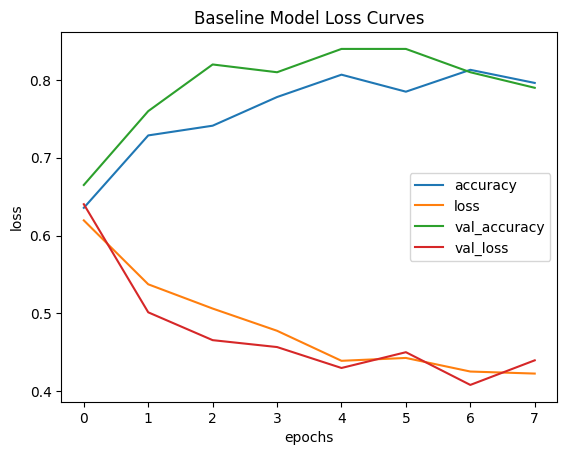

In [117]:
pd.DataFrame(baseline_model_loss.history).plot()
plt.title("Baseline Model Loss Curves")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [135]:
print(train_data.class_indices)

{'exterior': 0, 'interior': 1}


# Save the model

In [125]:
baseline_model.save("interior_prediction_model.keras")


# Test image

In [119]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [133]:
# Load image
image_path = 'home_office.jpg'
img = load_img(image_path, target_size=(224, 224))  # Resize to match input size
img_array = img_to_array(img)  # Convert to NumPy array
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

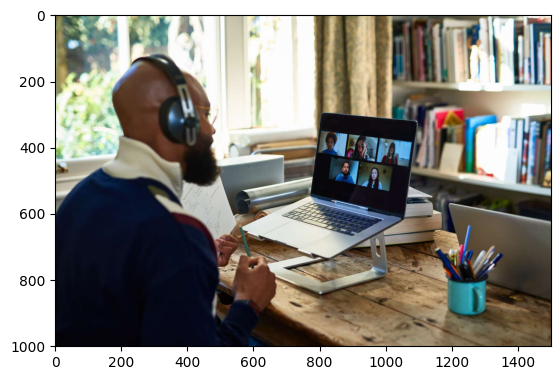

In [134]:
img = mpimg.imread(image_path)
plt.imshow(img)

In [136]:
# Predict
prediction = baseline_model.predict(img_array)
# Decode the prediction
if prediction[0][0] > 0.5:
    print("Prediction: Interior")
else:
    print("Prediction: Exterior")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Interior
